In [1]:
using ModelingToolkit
using MethodOfLines
using DifferentialEquations
using DomainSets
using FFTW
using CairoMakie

In [2]:
xleft::Float64 = 0.0
xright::Float64 = 1.0
t0::Float64 = 0.0
T::Float64 = 20.0
N = 100
order = 2
step = (xright - xleft)/N
grid = collect(xleft:step:xright)

#Definition of constants (placeholders):
gamma::Float64 = 0.5
gamma_3::Float64 = 0.25
c::Float64 = 1
omega_d::Float64 = 10

#Define parameters and variables (note: u(..) is valid as a symbolic function notation):
@parameters x t
@variables u(..)

#Define differential operators:
Dt = Differential(t)
Dx = Differential(x)
Dtt = Differential(t)^2
Dxx = Differential(x)^2

#Define source function (placeholder constant spatial term):
source_f(x, t) = 100 * exp(-40(x)^2) * sin(omega_d*t)

#Define initial condition (placeholder sinusoidal):
#u0(x, t) = exp(-(35*pi)*(x-0.5)^2)
u0(x, t) = 0
v0(x) = 0


#Define equation (with and without cubic damping term):
equation = [Dtt(u(x,t)) + gamma*Dt(u(x,t)) + gamma_3*(Dt(u(x,t)))^3 ~ c^2*Dxx(u(x,t)) + source_f(x, t)]
#equation = [Dtt(u(x,t)) ~ c^2*Dxx(u(x,t))]


#Define domains:
domains = [x ∈ Interval(xleft, xright), t ∈ Interval(t0, T)]

#Define boundary conditions:
bound_conditions = [u(x, 0) ~ u0(x, 0),
                     u(xleft, t) ~ 0,
                     u(xright, t) ~ 0,
                     Dt(u(x, 0)) ~ v0(x)]

4-element Vector{Equation}:
 u(x, 0) ~ 0
 u(0.0, t) ~ 0
 u(1.0, t) ~ 0
 Differential(t)(u(x, 0)) ~ 0

In [3]:
#Create PDE system and assign identifier (order matters: eq, bcs, domains, paramers, variables; format parameters and variables as lists, provide arguments whenever they exist):
@named pde_sys = PDESystem(equation, bound_conditions, domains, [x, t], [u(x,t)])

#Define a discretization (first argument specifies parameters to discretize, second indicates parameters to keep continuous, third provides the approximation order):
discretization = MOLFiniteDifference([x=>grid], t, approx_order=order)

#Proceed with discretization:
@time eq_discretized = discretize(pde_sys,discretization)

#Solve the resulting system (specified solver dictates whether or not time marching is used, as well as the method: Euler(), ImplicitEuler(), or Trapezoidal(), all with given time steps):
#Warning: if the time step is not explicitly given, solver may default to actual method of lines, instead of time marching
solution= solve(eq_discretized, ImplicitEuler(), dt=1e-2, saveat=0.01)

 32.179788 seconds (95.54 M allocations: 4.464 GiB, 4.83% gc time, 85.80% compilation time: 48% of which was recompilation)


retcode: Success
Interpolation: Dict{Num, Interpolations.GriddedInterpolation{Float64, 2, Matrix{Float64}, Interpolations.Gridded{Interpolations.Linear{Interpolations.Throw{Interpolations.OnGrid}}}, Tuple{Vector{Float64}, Vector{Float64}}}}
t: 2001-element Vector{Float64}:
  0.0
  0.01
  0.02
  0.03
  0.04
  0.05
  0.06
  0.07
  0.08
  0.09
  0.1
  0.11
  0.12
  ⋮
 19.89
 19.9
 19.91
 19.92
 19.93
 19.94
 19.95
 19.96
 19.97
 19.98
 19.99
 20.0ivs: 2-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 t
 xdomain:([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  19.91, 19.92, 19.93, 19.94, 19.95, 19.96, 19.97, 19.98, 19.99, 20.0], [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0])
u: Dict{Num, Matrix{Float64}} with 1 entry:
  u(x, t) => [0.0 0.0 … 0.0 0.0; -0.0 0.000608298 … 0.0331514 0.0295291; … ; -0…

In [4]:
#Plot results:
discrete_t = solution.t

sol_u = solution[u(x, t)]

Nx = length(grid)
Nt = length(solution.t)


2001

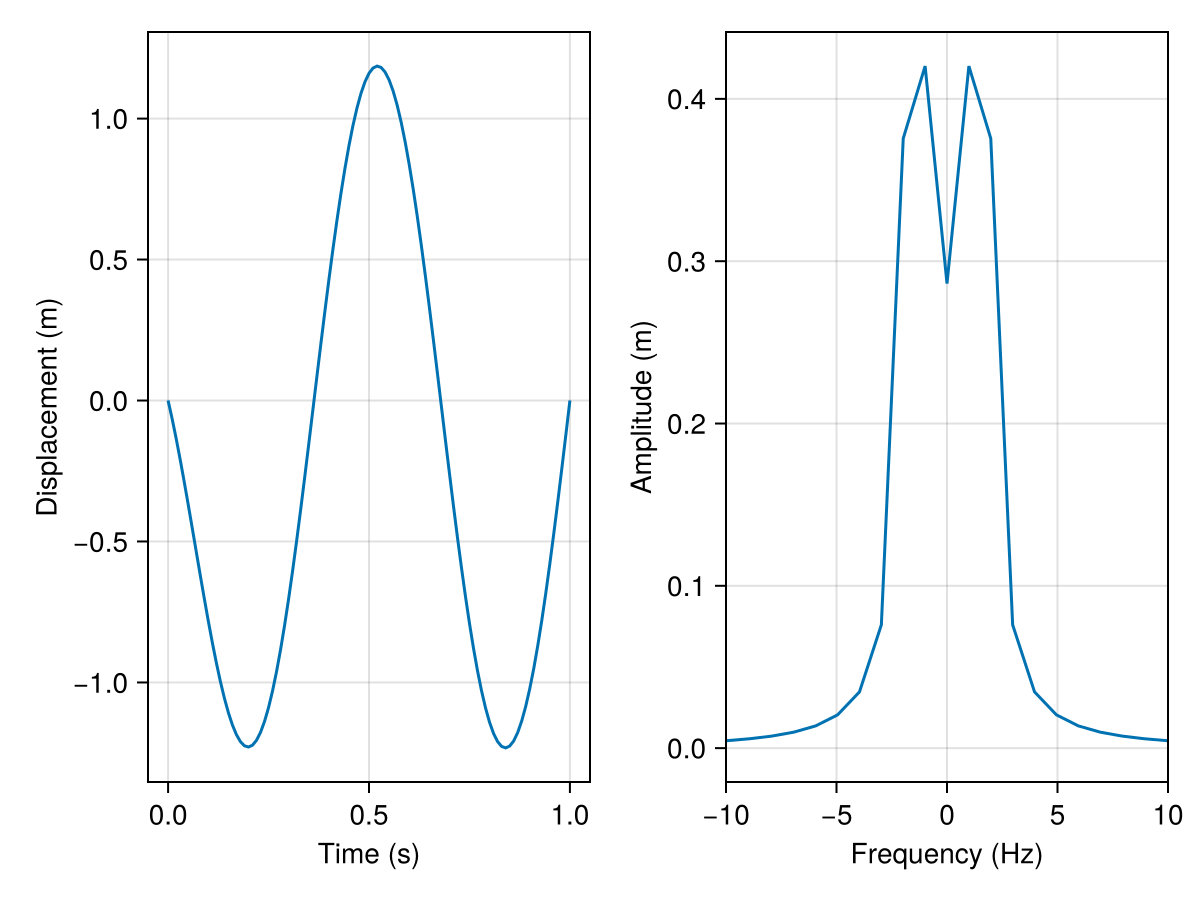

In [6]:
# Fourier Transform analysis

k = 1704
fs = N

u_at_k = sol_u[1:end, k]

F = fftshift(fft(u_at_k))
freqs =  fftshift(fftfreq(length(u_at_k), fs))

# Plotting with Makie
f = Figure()
ax1 = Axis(f[1, 1],
    xlabel = "Distance (m)",
    ylabel = "Displacement (m)",
)

ax2 = Axis(f[1, 2], xlabel = "Frequency (Hz)",
    ylabel = "Amplitude (m)",
)

lines!(ax1, grid, u_at_k)
lines!(ax2, freqs, abs.(F) / fs)
xlims!(ax2, -10, 10)

f